In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [12]:
aboutFPgrowth = '''
The FP-Growth (Frequent Pattern Growth) algorithm is an efficient method for mining frequent itemsets in large datasets, commonly used in market basket analysis.
Unlike the Apriori algorithm, which generates candidate itemsets and repeatedly scans the dataset, FP-Growth compresses the dataset into a compact data structure called the FP-tree (Frequent Pattern Tree)
and extracts frequent itemsets directly.

-> Steps of FP-Growth Algorithm
1. Build the FP-Tree
- Count the frequency of each item in the dataset.
- Remove infrequent items that do not meet the minimum support threshold.
- Sort the remaining items in descending order of frequency.
- Construct the FP-tree by inserting transactions, maintaining item order, and linking identical items via a header table.

2. Extract Frequent Itemsets Using Conditional FP-Trees
- Start with the least frequent item and traverse its linked nodes to gather conditional patterns (prefix paths).
- Construct a conditional FP-tree for these patterns.
- Recursively mine frequent itemsets from the conditional tree until no more frequent patterns can be found.

-> Advantages of FP-Growth
- Faster than Apriori: Avoids generating numerous candidate itemsets.
- Compact Data Representation: The FP-tree structure significantly reduces storage requirements.
- Efficient for Large Datasets: Processes large datasets with minimal scans.

-> Applications
- Market basket analysis (e.g., identifying frequently bought products).
- Recommendation systems.
- Web usage mining (e.g., analyzing user navigation patterns).

FP-Growth efficiently extracts frequent itemsets by recursively exploring compressed transactions,
making it ideal for large-scale data mining tasks.
'''
print(aboutFPgrowth)


The FP-Growth (Frequent Pattern Growth) algorithm is an efficient method for mining frequent itemsets in large datasets, commonly used in market basket analysis.
Unlike the Apriori algorithm, which generates candidate itemsets and repeatedly scans the dataset, FP-Growth compresses the dataset into a compact data structure called the FP-tree (Frequent Pattern Tree)
and extracts frequent itemsets directly.

-> Steps of FP-Growth Algorithm
1. Build the FP-Tree
- Count the frequency of each item in the dataset.
- Remove infrequent items that do not meet the minimum support threshold.
- Sort the remaining items in descending order of frequency.
- Construct the FP-tree by inserting transactions, maintaining item order, and linking identical items via a header table.

2. Extract Frequent Itemsets Using Conditional FP-Trees
- Start with the least frequent item and traverse its linked nodes to gather conditional patterns (prefix paths).
- Construct a conditional FP-tree for these patterns.
- R

In [13]:
# Load Dataset
df = pd.read_csv("Groceries_dataset.csv")

In [14]:
# Data Preprocessing: Transforming into Transactional Format
# Grouping items by Member_number to create a list of transactions
transactions = df.groupby("Member_number")["itemDescription"].apply(list).tolist()
print(transactions)

[['soda', 'canned beer', 'sausage', 'sausage', 'whole milk', 'whole milk', 'pickled vegetables', 'misc. beverages', 'semi-finished bread', 'hygiene articles', 'yogurt', 'pastry', 'salty snack'], ['frankfurter', 'frankfurter', 'beef', 'sausage', 'whole milk', 'soda', 'curd', 'white bread', 'whole milk', 'soda', 'whipped/sour cream', 'rolls/buns'], ['tropical fruit', 'butter milk', 'butter', 'frozen vegetables', 'sugar', 'specialty chocolate', 'whole milk', 'other vegetables'], ['sausage', 'root vegetables', 'rolls/buns', 'detergent', 'frozen meals', 'rolls/buns', 'dental care', 'rolls/buns'], ['other vegetables', 'pip fruit', 'root vegetables', 'canned beer', 'rolls/buns', 'whole milk', 'other vegetables', 'hygiene articles', 'whole milk', 'whole milk', 'frozen fish', 'red/blush wine', 'chocolate', 'shopping bags', 'dish cleaner', 'packaged fruit/vegetables', 'tropical fruit', 'rolls/buns', 'cling film/bags', 'chocolate', 'pastry'], ['whipped/sour cream', 'rolls/buns', 'margarine', 'rol

In [ ]:
# Defining the structure of an FP-tree node
class FPTreeNode:
    def __init__(self, item, count, parent):
        self.item = item  # Item name
        self.count = count  # Frequency count
        self.parent = parent  # Parent node
        self.children = {}  # Child nodes
        self.link = None  # Link to next node with the same item

    def increment(self, count):
        """Increment the count of the node."""
        self.count += count

In [16]:
# Function to build the FP-tree
def build_fp_tree(transactions, min_support):
    # Step 1: Count frequency of each item
    frequency = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            frequency[item] += 1

    # Step 2: Filter items based on min_support threshold
    frequency = {k: v for k, v in frequency.items() if v >= min_support}

    # If no items meet min_support, return empty tree
    if not frequency:
        return None, None

    # Step 3: Sort items by descending frequency
    sorted_items = sorted(frequency.keys(), key=lambda x: -frequency[x])

    # Step 4: Initialize FP-tree root and header table
    root = FPTreeNode(None, 0, None)
    header_table = {item: None for item in sorted_items}

    # Step 5: Insert transactions into the FP-tree
    for transaction in transactions:
        # Sort transaction items based on frequency and filter only frequent items
        sorted_transaction = [item for item in sorted(transaction, key=lambda x: -frequency.get(x, 0)) if item in frequency]
        if sorted_transaction:
            insert_tree(sorted_transaction, root, header_table)

    return root, header_table

In [ ]:
# Function to insert a transaction into the FP-tree
def insert_tree(items, node, header_table):
    first, rest = items[0], items[1:]

    # If the item already exists as a child, increment its count
    if first in node.children:
        node.children[first].increment(1)
    else:
        # Otherwise, create a new node
        node.children[first] = FPTreeNode(first, 1, node)

        # Update the header table to maintain node links
        if header_table[first] is None:
            header_table[first] = node.children[first]
        else:
            # for multiple occurrences of the same item, link to the next node
            # this is a linked list of nodes with the same item
            current = header_table[first]
            while current.link is not None:
                current = current.link
            current.link = node.children[first]

    # Recursively insert the rest of the transaction
    if rest:
        insert_tree(rest, node.children[first], header_table)


In [18]:
# Function to extract frequent itemsets from the FP-tree
def extract_frequent_itemsets(header_table, min_support):
    frequent_itemsets = {}

    # Traverse the header table to count item occurrences
    for item, node in header_table.items():
        count = 0
        while node is not None:
            count += node.count
            node = node.link

        # If item meets min_support, store it as a frequent itemset
        if count >= min_support:
            frequent_itemsets[item] = count

    return frequent_itemsets

In [19]:
# Define minimum support threshold
min_support = 5

# Build FP-tree
fp_tree, header_table = build_fp_tree(transactions, min_support)

# Extract frequent itemsets
frequent_itemsets = extract_frequent_itemsets(header_table, min_support)

In [20]:
# Visualization
# Sorting the frequent itemsets to get the top 5 most frequent items
sorted_items = sorted(frequent_itemsets.items(), key=lambda x: -x[1])[:5]
items, counts = zip(*sorted_items)

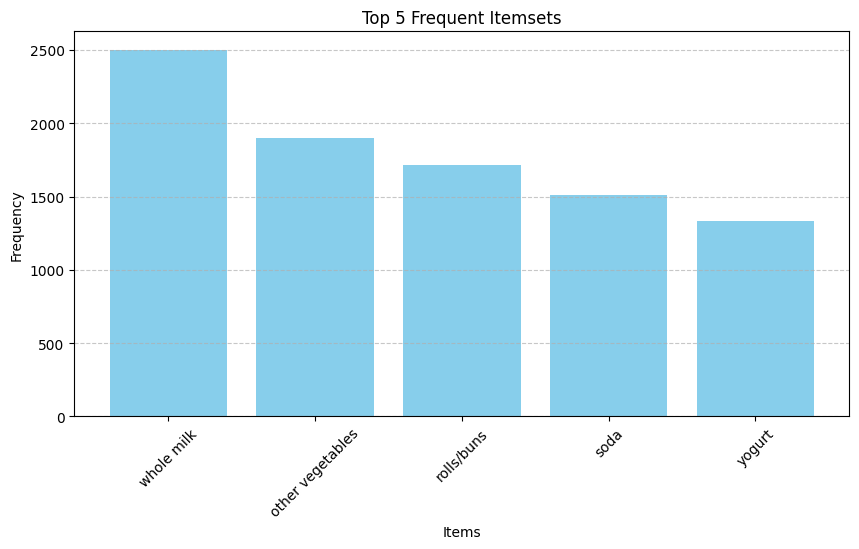

In [ ]:
# Plot a bar chart to visualize the top 5 frequent items
plt.figure(figsize=(10, 5))
plt.bar(items, counts, color='skyblue')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Top 5 Frequent Itemsets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()  

In [22]:
# summary
summary = """
The FP-Growth algorithm was implemented to extract frequent itemsets from the Groceries dataset.

Key Findings:
1. The dataset was transformed into a transactional format.
2. The FP-Growth algorithm identified frequent itemsets based on a minimum support of 5.
3. The top 5 frequent items were visualized using a bar chart.

Observations:
1. The algorithm successfully identified the most frequently purchased items.
2. The FP-tree structure allowed efficient compression of transactions, reducing redundancy and improving processing time.
3. The top 5 frequent items were visualized, indicating strong purchasing trends among customers.
4. Unlike Apriori, FP-Growth did not require multiple scans of the dataset, making it computationally efficient.
5. The results show that certain items appear frequently in customer transactions, which can be useful for market basket analysis.
"""

print(summary)


The FP-Growth algorithm was implemented to extract frequent itemsets from the Groceries dataset.

Key Findings:
1. The dataset was transformed into a transactional format.
2. The FP-Growth algorithm identified frequent itemsets based on a minimum support of 5.
3. The top 5 frequent items were visualized using a bar chart.

Observations:
1. The algorithm successfully identified the most frequently purchased items.
2. The FP-tree structure allowed efficient compression of transactions, reducing redundancy and improving processing time.
3. The top 5 frequent items were visualized, indicating strong purchasing trends among customers.
4. Unlike Apriori, FP-Growth did not require multiple scans of the dataset, making it computationally efficient.
5. The results show that certain items appear frequently in customer transactions, which can be useful for market basket analysis.

